# CS445: Term Project

#### Victor Weeks & Josh Lutz

Note: I think I am going to explore changing my idea to taking current inventory info and deciding how best to make a profit

### Introduction

In [479]:
from gw2spidy import Gw2Spidy as spidy # allows retrieval of market information
import numpy as np
import json
import random
import neuralnetworksA4 as nn
import matplotlib.pyplot as plt
%matplotlib inline

### Data

In [480]:
itemIDs = (19718,19720,19697,19680,19719,19738,19723,19710,
           19739,19740,19699,19683,19703,19687,19728,19733,19726,19713,
           19741,19742,19698,19682,19730,19734,19727,19714,
           19743,19744,19702,19686,19731,19736,19736,19724,19711,
           19748,19747,19700,19684,19729,19735,19722,19709,
           19745,19746,19701,19685,19732,19737,19725,19712)

In [987]:
itemTimeData = np.load('itemData.npy')
itemTimeData.shape

(10302, 13)

In [483]:
names = ['item_id', 'max_offer_price', 'min_sale_price', 'offer_availability', 'sale_availability', 'sale_price_change', 'offer_price_change', 'year', 'month', 'day', 'hour', 'minute', 'second']

In [1040]:
def makeItemData(itemID=19718, allItems=False, splitData=False, stepsAheadToPredict=4):
    itemTimeData = np.load('itemData.npy')
    if allItems:
        itemData = np.mean(itemTimeData[0:50], axis=0).reshape((1,-1))
        for bucket in itemTimeData[51::51]:
            itemData = np.vstack((itemData, np.mean(bucket.reshape((1,-1)), axis=0).reshape((1,-1))))
    else:
        itemData = itemTimeData[np.where(itemTimeData[:]==itemID)[0]]
    X = itemData[:-stepsAheadToPredict, 1:7].copy()
    T = itemData[stepsAheadToPredict:, 1:2].copy()
    if splitData:
        rows = np.arange(X.shape[0])
        nTrain = int(X.shape[0] * 0.7)
        Xtrain = X[rows[:nTrain],:]
        Ttrain = T[rows[:nTrain],:]
        Xtest = X[rows[nTrain:],:]
        Ttest = T[rows[nTrain:],:]
        return Xtrain, Ttrain, Xtest, Ttest
    else:        
        return X, T, itemData

Note: Had to make sure to copy the X and T data because of how the Time-Embedded data is accessed.

In [955]:
Xtrain, Ttrain, items = makeItemData(allItems=True) # training with all items
Xtest, Ttest, item1 = makeItemData(19735)
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((197, 6), (197, 1), (197, 6), (197, 1))

In [1041]:
Xtrain, Ttrain, Xtest, Ttest = makeItemData(19743, splitData=True)
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((139, 6), (139, 1), (60, 6), (60, 1))

#### Time-Embedding

In [967]:
def rollingWindows(X, windowSize):    
    nSamples, nAttributes = X.shape
    nWindows = nSamples - windowSize + 1
    # Shape of resulting matrix
    newShape = (nWindows, nAttributes * windowSize)
    itemSize = X.itemsize  # number of bytes
    # Number of bytes to increment to starting element in each dimension
    strides = (nAttributes * itemSize, itemSize)
    return np.lib.stride_tricks.as_strided(X, shape=newShape, strides=strides)

In [968]:
XtrainW = rollingWindows(Xtrain, 2)
TtrainW = rollingWindows(Ttrain, 2)
XtestW = rollingWindows(Xtest, 2)
TtestW = rollingWindows(Ttest, 2)
XtrainW.shape, TtrainW.shape, XtestW.shape, TtestW.shape

((136, 12), (136, 2), (59, 12), (59, 2))

In [969]:
Xtrain[0:2]

array([[   300,    358,  93115, 355427,      0,      0],
       [   285,    350,  91370, 356179,      0,      0]])

In [970]:
XtrainW[0]

array([   300,    358,  93115, 355427,      0,      0,    285,    350,
        91370, 356179,      0,      0])

In [971]:
nnet = nn.NeuralNetwork(Xtrain.shape[1], [10,10,10], Ttrain.shape[1])
nnet.train(Xtrain, Ttrain, 1000, verbose=True)

SCG: Iteration 100 fValue Eval 0.133401395769 Scale 1e-15
SCG: Iteration 200 fValue Eval 0.115342896284 Scale 1e-15
SCG: Iteration 300 fValue Eval 0.112612532106 Scale 1e-15
SCG: Iteration 400 fValue Eval 0.111883837808 Scale 1e-15
SCG: Iteration 500 fValue Eval 0.111381723925 Scale 1e-15
SCG: Iteration 600 fValue Eval 0.111257015791 Scale 1e-15
SCG: Iteration 700 fValue Eval 0.11123850861 Scale 1e-15
SCG: Iteration 800 fValue Eval 0.111227043672 Scale 1e-15
SCG: Iteration 900 fValue Eval 0.111223370637 Scale 1e-15
SCG: Iteration 1000 fValue Eval 0.111222581338 Scale 1e-15


NeuralNetwork(6, [10, 10, 10], 1)
   Network was trained for 1001 iterations that took 2.1363 seconds. Final error is 0.33350049675889226.

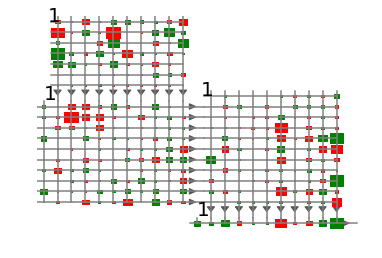

In [972]:
nnet.draw()

NeuralNetwork(6, [10, 10, 10], 1)
   Network was trained for 1001 iterations that took 2.1363 seconds. Final error is 0.33350049675889226.


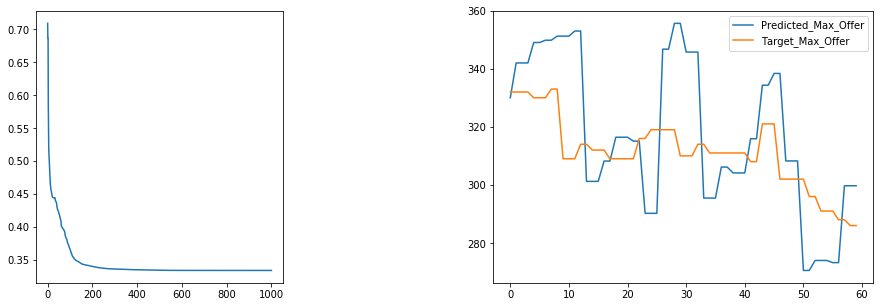

In [973]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(nnet.getErrors())
print(nnet)

Y = nnet.use(Xtest)
plt.subplot(1,2,2)
plt.plot(Y, label='Predicted_Max_Offer')
plt.plot(Ttest, label='Target_Max_Offer')
plt.legend();

In [974]:
keepTrain = [ len(np.unique(Trow))==1 for Trow in TtrainW ]
keepTest = [ len(np.unique(Trow))==1 for Trow in TtestW ]
sum(keepTrain)

86

In [975]:
XtrainW = XtrainW[keepTrain, :]
TtrainW = TtrainW[keepTrain, :]
TtrainW = TtrainW[:, 0:1] # reduce to single class label

XtestW = XtestW[keepTest, :]
TtestW = TtestW[keepTest, :]
TtestW = TtestW[:, 0:1] # reduce to single class label

In [979]:
nnet = nn.NeuralNetwork(XtrainW.shape[1], [10,10,10], TtrainW.shape[1])
nnet.train(XtrainW, TtrainW, 1000, verbose=True)

SCG: Iteration 100 fValue Eval 0.0320224998449 Scale 1e-15
SCG: Iteration 200 fValue Eval 0.0133380739718 Scale 1e-15
SCG: Iteration 300 fValue Eval 0.00560691214374 Scale 1e-15
SCG: Iteration 400 fValue Eval 0.00373856153622 Scale 1e-15
SCG: Iteration 500 fValue Eval 0.00244624739055 Scale 1e-15
SCG: Iteration 600 fValue Eval 0.00156094767693 Scale 1e-15
SCG: Iteration 700 fValue Eval 0.00114916640233 Scale 1e-15
SCG: Iteration 800 fValue Eval 0.000974526818224 Scale 1e-15
SCG: Iteration 900 fValue Eval 0.000784630379807 Scale 1e-15
SCG: Iteration 1000 fValue Eval 0.000671814979216 Scale 1e-15


NeuralNetwork(12, [10, 10, 10], 1)
   Network was trained for 1001 iterations that took 1.6501 seconds. Final error is 0.025919393882113475.

NeuralNetwork(12, [10, 10, 10], 1)
   Network was trained for 1001 iterations that took 1.6501 seconds. Final error is 0.025919393882113475.


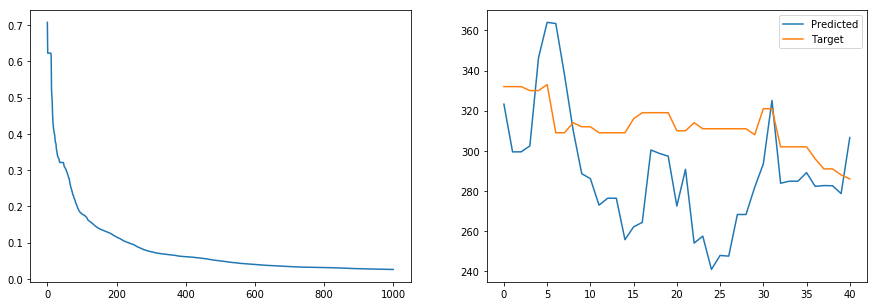

In [980]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(nnet.getErrors())
print(nnet)

Y = nnet.use(XtestW)
plt.subplot(1,2,2)
plt.plot(Y, label='Predicted')
plt.plot(TtestW, label='Target')
plt.legend();

In [ ]:
import pandas as pd
errors = []
hiddens = [0] + [[nu] * nl for nu in [1, 5, 10, 20, 50] for nl in [1, 2, 3, 4, 5]]
print('hiddens =', hiddens)
for hids in hiddens:
    nnet = nn.NeuralNetwork(XtrainW.shape[1], hids, TtrainW.shape[1])
    nnet.train(XtrainW, TtrainW, 1000)
    errors.append([hids, rmse(TtrainW, nnet.use(XtrainW)), rmse(TtestW, nnet.use(XtestW))])
errors = pd.DataFrame(errors)
print(errors)

plt.figure(figsize=(10, 10))
plt.plot(errors.values[:, 1:], 'o-')
plt.legend(('Tanh Train RMSE', 'Tanh Test RMSE'))
plt.xticks(range(errors.shape[0]), hiddens, rotation=30, horizontalalignment='right')
plt.grid(True)


## Methods

Notes: 
* could seperate all items into train and test data
* could train on one item, test on another

In [41]:
# This method acts as the reinforcement and accounts for the 15% handling cost for selling items on the market
def checkForProfit(price_sold, price_bought):
    profit = (price_sold - (price_sold * 0.15)) - price_bought
    if profit > 0:
        return 1
    elif profit < 0:
        return -1
    else:
        return 0

## Results

## Conclusions

## References